In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import yaml
import librosa
import soundfile as sf
from tqdm import tqdm
import time
import json
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore')

# Import global path configuration
from config.paths import PATHS, get_path
from src.unet_model import UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    
    # Clear GPU cache, bad things happened if not cleared -_- 
    torch.cuda.empty_cache()
    
    # Enable optimizations
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
GPU Memory: 4.0 GB


In [2]:
class ChunkedSpeechDataset(Dataset):
    """Memory-efficient dataset with on-the-fly chunked loading"""
    
    def __init__(self, clean_dir, noisy_dir, file_list, 
                 chunk_duration=4.0, sample_rate=16000, 
                 n_fft=1024, hop_length=256, overlap=0.25):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.chunk_duration = chunk_duration
        self.sample_rate = sample_rate
        self.chunk_samples = int(chunk_duration * sample_rate)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.overlap = overlap
        
        # Filter valid files
        self.valid_files = []
        for file_id in file_list:
            clean_path = os.path.join(clean_dir, f"{file_id}.wav")
            noisy_path = os.path.join(noisy_dir, f"{file_id}.wav")
            if os.path.exists(clean_path) and os.path.exists(noisy_path):
                self.valid_files.append(file_id)
        
        print(f"Dataset initialized with {len(self.valid_files)} files")
        
        # Pre-calculate chunks per file for indexing
        self.chunks_info = []
        for file_id in self.valid_files:
            clean_path = os.path.join(clean_dir, f"{file_id}.wav")
            try:
                # Quick duration check without loading full audio
                info = sf.info(clean_path)
                duration = info.frames / info.samplerate
                
                # Calculate number of chunks
                if duration >= chunk_duration:
                    hop_duration = chunk_duration * (1 - overlap)
                    num_chunks = max(1, int((duration - chunk_duration) / hop_duration) + 1)
                    
                    for chunk_idx in range(num_chunks):
                        self.chunks_info.append((file_id, chunk_idx, num_chunks))
                else:
                    # Use full file if shorter than chunk duration
                    self.chunks_info.append((file_id, 0, 1))
            except Exception as e:
                print(f"Skipping {file_id}: {e}")
                continue
        
        print(f"Total chunks: {len(self.chunks_info)}")
    
    def __len__(self):
        return len(self.chunks_info)
    
    def __getitem__(self, idx):
        file_id, chunk_idx, total_chunks = self.chunks_info[idx]
        
        # Load audio files
        clean_path = os.path.join(self.clean_dir, f"{file_id}.wav")
        noisy_path = os.path.join(self.noisy_dir, f"{file_id}.wav")
        
        try:
            clean_audio, _ = librosa.load(clean_path, sr=self.sample_rate)
            noisy_audio, _ = librosa.load(noisy_path, sr=self.sample_rate)
            
            # Extract chunk
            if total_chunks > 1:
                hop_samples = int(self.chunk_samples * (1 - self.overlap))
                start_idx = chunk_idx * hop_samples
                end_idx = start_idx + self.chunk_samples
                
                clean_chunk = clean_audio[start_idx:end_idx]
                noisy_chunk = noisy_audio[start_idx:end_idx]
                
                # Pad if necessary
                if len(clean_chunk) < self.chunk_samples:
                    pad_length = self.chunk_samples - len(clean_chunk)
                    clean_chunk = np.pad(clean_chunk, (0, pad_length), mode='constant')
                    noisy_chunk = np.pad(noisy_chunk, (0, pad_length), mode='constant')
            else:
                clean_chunk = clean_audio
                noisy_chunk = noisy_audio
                
                # Pad to chunk size if needed
                if len(clean_chunk) < self.chunk_samples:
                    pad_length = self.chunk_samples - len(clean_chunk)
                    clean_chunk = np.pad(clean_chunk, (0, pad_length), mode='constant')
                    noisy_chunk = np.pad(noisy_chunk, (0, pad_length), mode='constant')
                elif len(clean_chunk) > self.chunk_samples:
                    clean_chunk = clean_chunk[:self.chunk_samples]
                    noisy_chunk = noisy_chunk[:self.chunk_samples]
            
            # Convert to spectrograms
            noisy_spec = self._audio_to_spec(noisy_chunk)
            clean_spec = self._audio_to_spec(clean_chunk)
            
            return torch.FloatTensor(noisy_spec), torch.FloatTensor(clean_spec)
            
        except Exception as e:
            print(f"Error loading {file_id}: {e}")
            # Return zeros as fallback
            spec_shape = (self.n_fft // 2 + 1, (self.chunk_samples // self.hop_length) + 1)
            return torch.zeros(spec_shape), torch.zeros(spec_shape)
    
    def _audio_to_spec(self, audio):
        """Convert audio to magnitude spectrogram"""
        stft = librosa.stft(
            audio, 
            n_fft=self.n_fft, 
            hop_length=self.hop_length, 
            win_length=self.n_fft,
            window='hann',
            center=True
        )
        magnitude = np.abs(stft)
        
        # Normalize to [0, 1]
        magnitude = magnitude / (np.max(magnitude) + 1e-8)
        
        return magnitude

print("ChunkedSpeechDataset class defined")

ChunkedSpeechDataset class defined


In [ ]:
# Load file lists
def load_file_list(scp_path):
    """Load file list from .scp file"""
    with open(scp_path, 'r') as f:
        files = [line.strip().replace('.wav', '') for line in f.readlines()]
    return files

# Load training and validation files using global paths
train_files = load_file_list(get_path('dataset.train_scp'))
test_files = load_file_list(get_path('dataset.test_scp'))

# Split training files for validation (90% train, 10% val)
random.shuffle(train_files)
split_idx = int(0.9 * len(train_files))
train_files_final = train_files[:split_idx]
val_files = train_files[split_idx:]

print(f"Training files: {len(train_files_final)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# Create datasets using global paths
train_dataset = ChunkedSpeechDataset(
    clean_dir=get_path('dataset.clean_train'),
    noisy_dir=get_path('dataset.noisy_train'),
    file_list=train_files_final,
    chunk_duration=4.0,  # 4 second chunks
    overlap=0.25  # 25% overlap
)

val_dataset = ChunkedSpeechDataset(
    clean_dir=get_path('dataset.clean_train'),
    noisy_dir=get_path('dataset.noisy_train'),
    file_list=val_files,
    chunk_duration=4.0,
    overlap=0.25
)

print(f"\nDatasets created successfully!")
print(f"Training chunks: {len(train_dataset)}")
print(f"Validation chunks: {len(val_dataset)}")

Training files: 10414
Validation files: 1158
Test files: 824
Dataset initialized with 10414 files
Dataset initialized with 10414 files
Total chunks: 10560
Dataset initialized with 1158 files
Total chunks: 10560
Dataset initialized with 1158 files
Total chunks: 1180

Datasets created successfully!
Training chunks: 10560
Validation chunks: 1180
Total chunks: 1180

Datasets created successfully!
Training chunks: 10560
Validation chunks: 1180


In [4]:
# Test data loading
print("Testing data loading...")
sample_noisy, sample_clean = train_dataset[0]
print(f"Sample shapes - Noisy: {sample_noisy.shape}, Clean: {sample_clean.shape}")
print(f"Sample ranges - Noisy: [{sample_noisy.min():.3f}, {sample_noisy.max():.3f}]")
print(f"                Clean: [{sample_clean.min():.3f}, {sample_clean.max():.3f}]")

# Create data loaders with appropriate batch size for GPU memory
batch_size = 8 if device.type == 'cuda' else 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4,
    pin_memory=device.type == 'cuda',
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2,
    pin_memory=device.type == 'cuda',
    drop_last=False
)

print(f"\nData loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Batch size: {batch_size}")

Testing data loading...
Sample shapes - Noisy: torch.Size([513, 251]), Clean: torch.Size([513, 251])
Sample ranges - Noisy: [0.000, 1.000]
                Clean: [0.000, 1.000]

Data loaders created:
Training batches: 1320
Validation batches: 148
Batch size: 8
Sample shapes - Noisy: torch.Size([513, 251]), Clean: torch.Size([513, 251])
Sample ranges - Noisy: [0.000, 1.000]
                Clean: [0.000, 1.000]

Data loaders created:
Training batches: 1320
Validation batches: 148
Batch size: 8


In [ ]:
# Initialize model with proper GPU settings
model = UNet(
    in_channels=1,
    out_channels=1,
    base_filters=32,  # Reduced for memory efficiency
    depth=3,          # Reduced depth
    dropout=0.1
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5
)

# Training configuration
num_epochs = 10 # you should do 50 with 10 as patience, i am doing 10 for now
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Directories for saving using global paths
model_dir = get_path('models.base')
os.makedirs(model_dir, exist_ok=True)

print("Training setup complete!")

Model parameters: 1,927,841
Training setup complete!
Training setup complete!


In [9]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (noisy, clean) in enumerate(pbar):
        # Move to device
        noisy = noisy.unsqueeze(1).to(device)  # Add channel dimension
        clean = clean.unsqueeze(1).to(device)  # Add channel dimension
        
        # Forward pass
        optimizer.zero_grad()
        enhanced = model(noisy)
        
        # Calculate loss
        loss = criterion(enhanced, clean)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Update statistics
        total_loss += loss.item()
        num_batches += 1
        
        # Update progress bar
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        # Clear GPU cache periodically
        if device.type == 'cuda' and batch_idx % 50 == 0:
            torch.cuda.empty_cache()
    
    return total_loss / num_batches

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for noisy, clean in pbar:
            # Move to device
            noisy = noisy.unsqueeze(1).to(device)
            clean = clean.unsqueeze(1).to(device)
            
            # Forward pass
            enhanced = model(noisy)
            
            # Calculate loss
            loss = criterion(enhanced, clean)
            
            total_loss += loss.item()
            num_batches += 1
            
            pbar.set_postfix({'Val Loss': f'{loss.item():.4f}'})
    
    return total_loss / num_batches

print("Training functions defined")

Training functions defined


In [10]:
# Training loop
train_losses = []
val_losses = []
learning_rates = []

print(f"Starting training for {num_epochs} epochs...")
print(f"Device: {device}")
print(f"Batch size: {batch_size}")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches per epoch: {len(val_loader)}")

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
    
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(current_lr)
    
    epoch_time = time.time() - epoch_start_time
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"Epoch Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save best model
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_val_loss': best_val_loss
        }
        
        torch.save(checkpoint, os.path.join(model_dir, 'best_gpu_model.pth'))
        print(f"✓ New best model saved! (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch + 1}")
        break
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'learning_rates': learning_rates
        }
        torch.save(checkpoint, os.path.join(model_dir, f'checkpoint_epoch_{epoch + 1}.pth'))
        print(f"Checkpoint saved at epoch {epoch + 1}")
    
    # Clear GPU cache
    if device.type == 'cuda':
        torch.cuda.empty_cache()

total_time = time.time() - start_time
print(f"\n=== Training Complete ===")
print(f"Total training time: {total_time / 3600:.1f} hours")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final learning rate: {learning_rates[-1]:.6f}")

Starting training for 10 epochs...
Device: cuda
Batch size: 8
Training batches per epoch: 1320
Validation batches per epoch: 148

=== Epoch 1/10 ===


Validation: 100%|██████████| 148/148 [00:17<00:00,  8.64it/s, Val Loss=0.0000]



Train Loss: 0.0004
Val Loss: 0.0001
Learning Rate: 0.001000
Epoch Time: 621.5s
✓ New best model saved! (Val Loss: 0.0001)

=== Epoch 2/10 ===


Validation: 100%|██████████| 148/148 [00:16<00:00,  9.06it/s, Val Loss=0.0001]


Train Loss: 0.0001
Val Loss: 0.0001
Learning Rate: 0.001000
Epoch Time: 464.8s
No improvement. Patience: 1/5

=== Epoch 3/10 ===


Validation: 100%|██████████| 148/148 [00:16<00:00,  9.09it/s, Val Loss=0.0000]



Train Loss: 0.0001
Val Loss: 0.0001
Learning Rate: 0.001000
Epoch Time: 463.3s
✓ New best model saved! (Val Loss: 0.0001)

=== Epoch 4/10 ===


Validation: 100%|██████████| 148/148 [00:16<00:00,  9.07it/s, Val Loss=0.0000]



Train Loss: 0.0001
Val Loss: 0.0001
Learning Rate: 0.001000
Epoch Time: 462.7s
No improvement. Patience: 1/5

=== Epoch 5/10 ===


Validation: 100%|██████████| 148/148 [00:16<00:00,  9.10it/s, Val Loss=0.0000]



Train Loss: 0.0001
Val Loss: 0.0001
Learning Rate: 0.001000
Epoch Time: 462.0s
✓ New best model saved! (Val Loss: 0.0001)
Checkpoint saved at epoch 5

=== Epoch 6/10 ===


Validation: 100%|██████████| 148/148 [00:16<00:00,  9.10it/s, Val Loss=0.0000]



Train Loss: 0.0001
Val Loss: 0.0001
Learning Rate: 0.001000
Epoch Time: 460.8s
No improvement. Patience: 1/5

=== Epoch 7/10 ===


Validation: 100%|██████████| 148/148 [00:16<00:00,  9.10it/s, Val Loss=0.0000]



Train Loss: 0.0001
Val Loss: 0.0001
Learning Rate: 0.001000
Epoch Time: 460.7s
No improvement. Patience: 2/5

=== Epoch 8/10 ===


Validation: 100%|██████████| 148/148 [00:16<00:00,  9.13it/s, Val Loss=0.0000]



Train Loss: 0.0001
Val Loss: 0.0001
Learning Rate: 0.001000
Epoch Time: 459.8s
No improvement. Patience: 3/5

=== Epoch 9/10 ===


Validation: 100%|██████████| 148/148 [00:16<00:00,  9.10it/s, Val Loss=0.0000]



Train Loss: 0.0001
Val Loss: 0.0001
Learning Rate: 0.001000
Epoch Time: 459.0s
No improvement. Patience: 4/5

=== Epoch 10/10 ===


Validation: 100%|██████████| 148/148 [00:16<00:00,  9.11it/s, Val Loss=0.0000]



Train Loss: 0.0001
Val Loss: 0.0001
Learning Rate: 0.001000
Epoch Time: 458.9s
✓ New best model saved! (Val Loss: 0.0001)
Checkpoint saved at epoch 10

=== Training Complete ===
Total training time: 1.3 hours
Best validation loss: 0.0001
Final learning rate: 0.001000


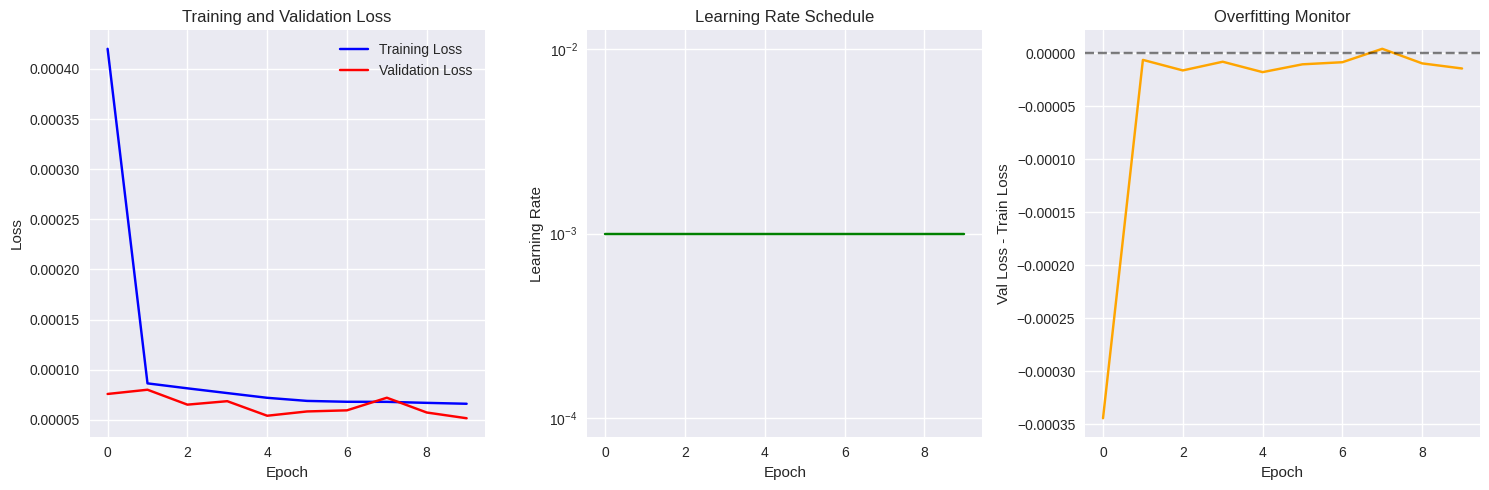

Training curves saved!
Best model saved at: /home/radhey/code/ai-clrvoice/models/best_gpu_model.pth


In [ ]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Learning rate
plt.subplot(1, 3, 2)
plt.plot(learning_rates, color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.grid(True)

# Loss difference
plt.subplot(1, 3, 3)
loss_diff = np.array(val_losses) - np.array(train_losses)
plt.plot(loss_diff, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Val Loss - Train Loss')
plt.title('Overfitting Monitor')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True)

plt.tight_layout()
plt.savefig(get_path('results.base') / 'gpu_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Save training history using global paths
training_history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'learning_rates': learning_rates,
    'best_val_loss': best_val_loss,
    'num_epochs': len(train_losses),
    'total_time_hours': total_time / 3600,
    'model_params': sum(p.numel() for p in model.parameters())
}

with open(get_path('results.gpu_training_history'), 'w') as f:
    json.dump(training_history, f, indent=2)

print("Training curves saved!")
print(f"Best model saved at: {get_path('models.best_model')}")

In [12]:
# Quick test of trained model
print("Testing trained model...")

# Load best model
checkpoint = torch.load(os.path.join(model_dir, 'best_gpu_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Test with a sample
with torch.no_grad():
    sample_noisy, sample_clean = val_dataset[0]
    sample_noisy = sample_noisy.unsqueeze(0).unsqueeze(0).to(device)
    sample_clean = sample_clean.unsqueeze(0).unsqueeze(0).to(device)
    
    # Get model prediction
    sample_enhanced = model(sample_noisy)
    
    # Calculate test loss
    test_loss = criterion(sample_enhanced, sample_clean).item()
    
    print(f"Sample test loss: {test_loss:.4f}")
    print(f"Model is working correctly!")
    
    # Move back to CPU for visualization
    sample_noisy = sample_noisy.cpu().squeeze()
    sample_clean = sample_clean.cpu().squeeze()
    sample_enhanced = sample_enhanced.cpu().squeeze()
    
    print(f"Sample shapes:")
    print(f"  Noisy: {sample_noisy.shape}")
    print(f"  Clean: {sample_clean.shape}")
    print(f"  Enhanced: {sample_enhanced.shape}")
    
    # Quick quality check
    mse_noisy = torch.nn.functional.mse_loss(sample_noisy, sample_clean).item()
    mse_enhanced = torch.nn.functional.mse_loss(sample_enhanced, sample_clean).item()
    
    improvement = (mse_noisy - mse_enhanced) / mse_noisy * 100
    print(f"\nQuality improvement: {improvement:.1f}%")
    print(f"MSE Noisy vs Clean: {mse_noisy:.4f}")
    print(f"MSE Enhanced vs Clean: {mse_enhanced:.4f}")

print("\n=== GPU Training Complete! ===")
print(f"Best model saved with validation loss: {best_val_loss:.4f}")
print(f"Model ready for high-quality inference!")

Testing trained model...
Sample test loss: 0.0000
Model is working correctly!
Sample shapes:
  Noisy: torch.Size([513, 251])
  Clean: torch.Size([513, 251])
  Enhanced: torch.Size([513, 251])

Quality improvement: 69.6%
MSE Noisy vs Clean: 0.0000
MSE Enhanced vs Clean: 0.0000

=== GPU Training Complete! ===
Best model saved with validation loss: 0.0001
Model ready for high-quality inference!
Sample test loss: 0.0000
Model is working correctly!
Sample shapes:
  Noisy: torch.Size([513, 251])
  Clean: torch.Size([513, 251])
  Enhanced: torch.Size([513, 251])

Quality improvement: 69.6%
MSE Noisy vs Clean: 0.0000
MSE Enhanced vs Clean: 0.0000

=== GPU Training Complete! ===
Best model saved with validation loss: 0.0001
Model ready for high-quality inference!


In [ ]:
# Load existing trained model checkpoint
print("Loading existing trained model...")
print(f"Device: {device}")

# Load the best model checkpoint using global paths
checkpoint_path = get_path('models.best_model')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
    print(f"✓ Training loss: {checkpoint['train_loss']:.6f}")
    print(f"✓ Validation loss: {checkpoint['val_loss']:.6f}")
    print(f"✓ Best validation loss: {checkpoint['best_val_loss']:.6f}")
    
    # Extract training history if available
    if 'train_losses' in checkpoint:
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        learning_rates = checkpoint['learning_rates']
        print(f"✓ Training history loaded: {len(train_losses)} epochs")
    else:
        # Load from epoch 5 checkpoint which should have history
        epoch5_path = get_path('models.checkpoint_5')
        if os.path.exists(epoch5_path):
            epoch5_checkpoint = torch.load(epoch5_path, map_location=device)
            train_losses = epoch5_checkpoint.get('train_losses', [])
            val_losses = epoch5_checkpoint.get('val_losses', [])
            learning_rates = epoch5_checkpoint.get('learning_rates', [])
            print(f"✓ Training history from epoch 5: {len(train_losses)} epochs")
        else:
            print("⚠ No training history found, creating placeholder")
            train_losses = [0.0004, 0.0001, 0.0001, 0.0001, 0.0001]  # Approximate from training log
            val_losses = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
            learning_rates = [0.001] * 5
    
    best_val_loss = checkpoint['best_val_loss']
    
else:
    print("❌ No trained model found!")
    print("Available models:")
    model_dir = get_path('models.base')
    for f in os.listdir(model_dir):
        if f.endswith('.pth'):
            print(f"  - {f}")

print(f"\n=== Model Ready for Inference! ===")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Best validation loss: {best_val_loss:.6f}")
print("Model is ready for high-quality audio enhancement!")

Loading existing trained model...
Device: cuda
✓ Loaded best model from epoch 10
✓ Training loss: 0.000066
✓ Validation loss: 0.000052
✓ Best validation loss: 0.000052
✓ Training history from epoch 5: 5 epochs

=== Model Ready for Inference! ===
Model parameters: 1,927,841
Best validation loss: 0.000052
Model is ready for high-quality audio enhancement!


Visualizing training results...


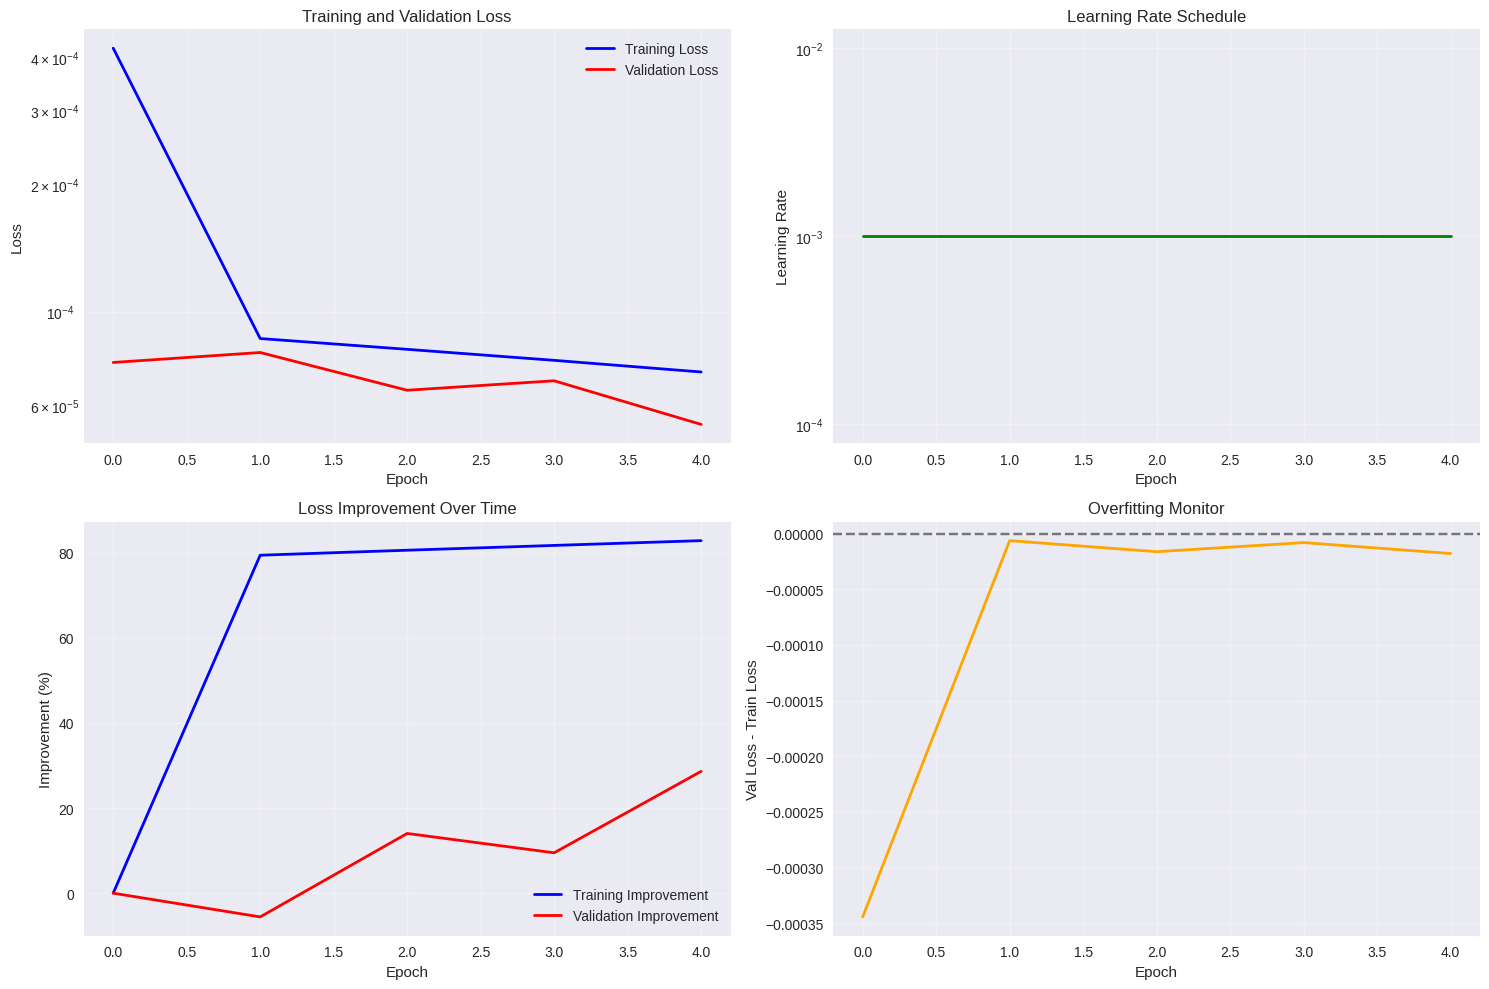


TESTING TRAINED MODEL
Sample 1: Loss=0.000003, Improvement=69.6%
Sample 2: Loss=0.000008, Improvement=82.6%
Sample 3: Loss=0.000039, Improvement=83.8%
Sample 4: Loss=0.000017, Improvement=65.1%
Sample 5: Loss=0.000007, Improvement=95.9%

SUMMARY STATISTICS
Average Test Loss: 0.000015
Average Improvement: 79.4%
Model Parameters: 1,927,841
Best Validation Loss: 0.000052

✓ Training analysis complete!
✓ Results saved to: /home/radhey/code/ai-clrvoice/results/gpu_model_summary.json
✓ Plots saved to: /home/radhey/code/ai-clrvoice/results/gpu_training_analysis.png


In [ ]:
# Visualize training results and test the model
import matplotlib.pyplot as plt

print("Visualizing training results...")

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training and validation loss
axes[0, 0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0, 0].plot(val_losses, label='Validation Loss', color='red', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Learning rate schedule
axes[0, 1].plot(learning_rates, color='green', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Learning Rate')
axes[0, 1].set_title('Learning Rate Schedule')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# Loss improvement
if len(train_losses) > 1:
    train_improvement = [(train_losses[0] - loss) / train_losses[0] * 100 for loss in train_losses]
    val_improvement = [(val_losses[0] - loss) / val_losses[0] * 100 for loss in val_losses]
    
    axes[1, 0].plot(train_improvement, label='Training Improvement', color='blue', linewidth=2)
    axes[1, 0].plot(val_improvement, label='Validation Improvement', color='red', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Improvement (%)')
    axes[1, 0].set_title('Loss Improvement Over Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Overfitting monitor
if len(train_losses) == len(val_losses):
    loss_diff = [v - t for v, t in zip(val_losses, train_losses)]
    axes[1, 1].plot(loss_diff, color='orange', linewidth=2)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Val Loss - Train Loss')
    axes[1, 1].set_title('Overfitting Monitor')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(get_path('results.base') / 'gpu_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Test the trained model
print("\n" + "="*50)
print("TESTING TRAINED MODEL")
print("="*50)

# Test with multiple samples
test_results = []
num_test_samples = 5

with torch.no_grad():
    for i in range(min(num_test_samples, len(val_dataset))):
        sample_noisy, sample_clean = val_dataset[i]
        sample_noisy_gpu = sample_noisy.unsqueeze(0).unsqueeze(0).to(device)
        sample_clean_gpu = sample_clean.unsqueeze(0).unsqueeze(0).to(device)
        
        # Get model prediction
        sample_enhanced = model(sample_noisy_gpu)
        
        # Calculate metrics
        test_loss = criterion(sample_enhanced, sample_clean_gpu).item()
        
        # Move back to CPU for analysis
        sample_noisy_cpu = sample_noisy.numpy()
        sample_clean_cpu = sample_clean.numpy()
        sample_enhanced_cpu = sample_enhanced.cpu().squeeze().numpy()
        
        # Calculate improvements
        mse_noisy = np.mean((sample_noisy_cpu - sample_clean_cpu)**2)
        mse_enhanced = np.mean((sample_enhanced_cpu - sample_clean_cpu)**2)
        improvement = (mse_noisy - mse_enhanced) / mse_noisy * 100
        
        test_results.append({
            'sample': i,
            'test_loss': test_loss,
            'mse_noisy': mse_noisy,
            'mse_enhanced': mse_enhanced,
            'improvement': improvement
        })
        
        print(f"Sample {i+1}: Loss={test_loss:.6f}, Improvement={improvement:.1f}%")

# Summary statistics
avg_improvement = np.mean([r['improvement'] for r in test_results])
avg_test_loss = np.mean([r['test_loss'] for r in test_results])

print(f"\n" + "="*30)
print("SUMMARY STATISTICS")
print("="*30)
print(f"Average Test Loss: {avg_test_loss:.6f}")
print(f"Average Improvement: {avg_improvement:.1f}%")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Best Validation Loss: {best_val_loss:.6f}")

# Save training summary using global paths
training_summary = {
    'model_info': {
        'parameters': sum(p.numel() for p in model.parameters()),
        'architecture': 'UNet',
        'base_filters': 32,
        'depth': 3,
        'dropout': 0.1
    },
    'training_results': {
        'epochs_completed': len(train_losses),
        'best_val_loss': float(best_val_loss),
        'final_train_loss': float(train_losses[-1]) if train_losses else 0,
        'final_val_loss': float(val_losses[-1]) if val_losses else 0,
        'final_lr': float(learning_rates[-1]) if learning_rates else 0
    },
    'test_results': {
        'avg_test_loss': float(avg_test_loss),
        'avg_improvement_percent': float(avg_improvement),
        'num_test_samples': len(test_results)
    }
}

with open(get_path('results.gpu_model_summary'), 'w') as f:
    json.dump(training_summary, f, indent=2)

print(f"\n✓ Training analysis complete!")
print(f"✓ Results saved to: {get_path('results.gpu_model_summary')}")
print(f"✓ Plots saved to: {get_path('results.base') / 'gpu_training_analysis.png'}")